# Exercise 7: ARIMAX versus ARDL models

## Compute continuous quarterly returns of BNP 5Y CDS:

In [1]:
#libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.stats.diagnostic as dg
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('BNP_CDS.xlsx', index_col=0)
df = df.sort_values(by='Date', ascending=True)

df_logret = np.log(df['Last Price'].iloc[1:]).diff().dropna()
df_quarterly = df_logret.resample('Q').sum() #== because log returns are additive
df_quarterly.tail()

Date
2021-09-30    0.046879
2021-12-31   -0.045444
2022-03-31    0.377333
2022-06-30    0.420382
2022-09-30    0.160980
Freq: Q-DEC, Name: Last Price, dtype: float64

In [3]:
#split in train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022):
df_train = df_quarterly.loc['2010-03-31' : '2021-03-31']
df_test = df_quarterly.loc['2021-06-30' : '2022-09-30']

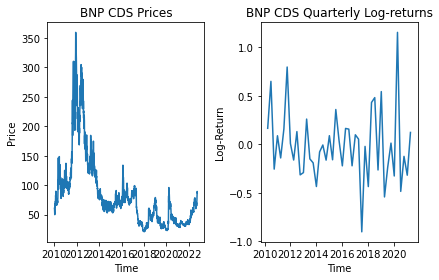

In [4]:
#================== Visual representation ===================

# Check the CDS price's fluctuation
plt.subplot(1, 2, 1)
plt.plot(df['Last Price'])
plt.title("BNP CDS Prices")
plt.xlabel('Time')
plt.ylabel('Price')
# Check the evolution of log-returns
plt.subplot(1, 2, 2)
plt.plot(df_train)
plt.title("BNP CDS Quarterly Log-returns")
plt.xlabel('Time')
plt.ylabel('Log-Return')
plt.tight_layout()

## Visual inspection of ACF/PACF and Unit Root detection

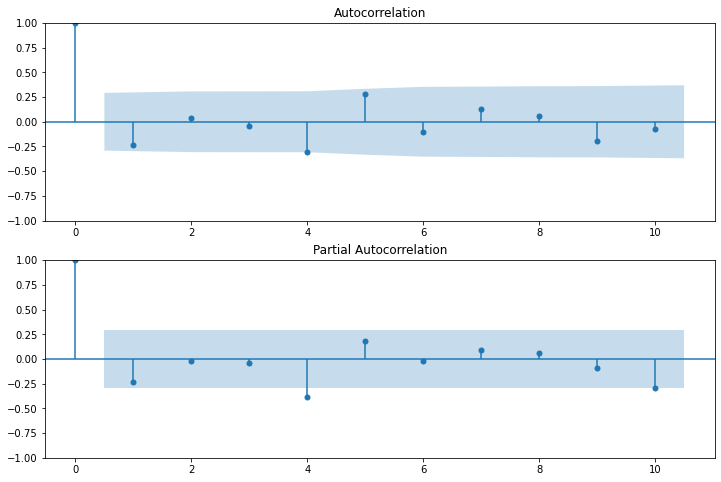

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train, lags=10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=10, ax=ax2) 

In [6]:
test = adfuller(df_train)
df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['Output'])
df_adf['Output']['Test Statistic Value'] = test[0]
df_adf['Output']['p-value'] = test[1]
df_adf['Output']['Lags Used'] = test[2]
df_adf['Output']['Number of Observations Used'] = test[3]
df_adf['Output']['Critical Value(1%)'] = test[4]['1%']
df_adf['Output']['Critical Value(5%)'] = test[4]['5%']
df_adf['Output']['Critical Value(10%)'] = test[4]['10%']
df_adf

Output
Test Statistic Value        -4.904038
p-value                      0.000034
Lags Used                           3
Number of Observations Used        41
Critical Value(1%)          -3.600983
Critical Value(5%)          -2.935135
Critical Value(10%)         -2.605963

The null hypothesis is rejected: the process is **stationary** (pvalue above thresholds & t-stat > critical value). There is no need for differentiating.

## Fitting an ARIMA model:

In [7]:
from itertools import product
ar_order = [0, 1, 2, 3, 4, 5]
ma_order = [0, 1, 2, 3, 4, 5]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

for n in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*n)) 
    try:
        arma_model  = tsa.arima.model.ARIMA(df_train, order= (n[0], 0, n[1])).fit()
        n.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        n.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 - ma:0
fitting: ar:0 - ma:1
fitting: ar:0 - ma:2
fitting: ar:0 - ma:3
fitting: ar:0 - ma:4
fitting: ar:0 - ma:5
fitting: ar:1 - ma:0
fitting: ar:1 - ma:1
fitting: ar:1 - ma:2
fitting: ar:1 - ma:3
fitting: ar:1 - ma:4
fitting: ar:1 - ma:5
fitting: ar:2 - ma:0
fitting: ar:2 - ma:1
fitting: ar:2 - ma:2
fitting: ar:2 - ma:3
fitting: ar:2 - ma:4
fitting: ar:2 - ma:5
fitting: ar:3 - ma:0
fitting: ar:3 - ma:1
fitting: ar:3 - ma:2
fitting: ar:3 - ma:3
fitting: ar:3 - ma:4
fitting: ar:3 - ma:5
fitting: ar:4 - ma:0
fitting: ar:4 - ma:1
fitting: ar:4 - ma:2
fitting: ar:4 - ma:3
fitting: ar:4 - ma:4
fitting: ar:4 - ma:5
fitting: ar:5 - ma:0
fitting: ar:5 - ma:1
fitting: ar:5 - ma:2
fitting: ar:5 - ma:3
fitting: ar:5 - ma:4
fitting: ar:5 - ma:5
criterion
     ar_order  ma_order       aic       bic
0          0         0  0.041341  0.044954
1          0         1  0.040809  0.046229
2          0         2  0.042723  0.049949
3          0         3  0.042663  0.051697
4          0      

In [8]:
#========= confirming order chosen ============
select_order = sm.tsa.arma_order_select_ic(df_train,max_ar=5,max_ma=5,ic='aic')['aic_min_order']
print(f"The optimal order is: {select_order}")

The optimal order is: (4, 1)


**Order chosen is an ARIMA (4,0,1)** based on the AIC criteria

## Test for ARCH effect:

First we take the residuals from the ARMA(1,1) estimation, square them and regress them on q lagged values.

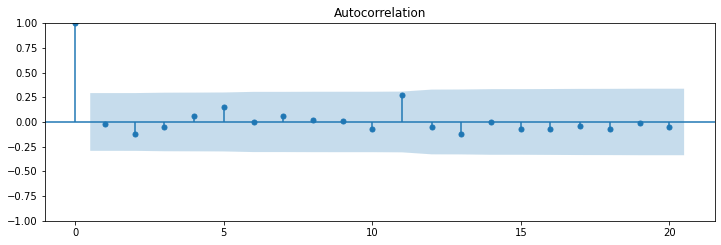

In [9]:
#===== ARCH test with the Ljung-Box on the squared residuals =======================

df_train_res = df_train - np.mean(df_train)
sq_df_train_res = df_train_res**2

#======== ACF and of squared residuals: ========
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sq_df_train_res, lags=20, ax=ax1)

According to the ACF of the squared residuals, we see no significant positive autocorrelation betwteen the residuals and thus reject the null hypothesis.

## Test for GARCH process features:

First we construct the standardized residuals and run a normality test on them (Jarque-Bera test):

In [10]:
df_train_res = (df_train - np.mean(df_train)) / np.std(df_train)
nb_obs = len(df_train_res)

jb = sm.stats.stattools.jarque_bera(df_train_res, axis=0)
print(jb)

(7.302026380062027, 0.025964808162326637, 0.7039375837380424, 4.382859928615549)


This Jarque-Bera test is a goodness-of-fit test that returns the JB t-stat, p-value, skewness and the kurtosis. **We don't reject the null hypothesis of a normal distribution** (p-value being above the threshold) and confirm the absence of a GARCH process.

## Forecast an ARIMA(4,0,1) for the next 6 periods:

In [11]:
#from statsmodels.tsa.arima_model import ARIMA
#### Other package that allows to see the confidence interval while plotting the forecast
#arma_model  = ARIMA(df_train, order=(4,0,1)).fit()
#arma_model.summary()

In [12]:
#### Old code suggested by Queen Ariane. Very good and efficient but no confidence interval rn
arma_model  = tsa.arima.model.ARIMA(df_train, order=(4,0,1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Last Price   No. Observations:                   45
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 -12.740
Date:                Sat, 24 Dec 2022   AIC                             39.480
Time:                        13:46:03   BIC                             52.127
Sample:                    03-31-2010   HQIC                            44.195
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0103      0.034     -0.306      0.759      -0.076       0.056
ar.L1         -0.7981      0.322     -2.481      0.013      -1.429      -0.168
ar.L2         -0.2061      0.251     -0.823      0.411      -0.697       0.285
ar.L3         -0.1818      0.219     -0.828      0.407      -0.612       0.248
ar.L4         -0.4315      0.150     -2.878      0.004      -0.725      -0.138
ma.L1          0.6998      0.340      2.057      0.040       0.033       1.367
sigma2         0.0998      0.022      4.533      0.000       0.057       0.143
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.97   Prob(JB):                         0.89
Heteroskedasticity (H):               1.05   Skew:                             0.08
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1, ar.L4 and ma.L1 coefficient are significant (with p-value below 0.05)

In [13]:
# Forecast
#forecast_arma, std_error, IC = arma_model.forecast(6, alpha=0.05)
forecast_arma = arma_model.forecast(6)

# Prepare the series to plot training, forecast and acutal data 
#fc_series = pd.Series(forecast_arma, index=df_test.index)
#lower_series = pd.Series(IC[:, 0], index=df_test.index)
#upper_series = pd.Series(IC[:, 1], index=df_test.index)

# If you need to check the forecasted data
forecast_arma = pd.DataFrame({'Projected return' : forecast_arma})
forecast_arma 
# Graph comparison of forecasts vs. actual data
#plt.figure(figsize=(12,8)) # If you add ", dpi=100" you have a wider plot
#plt.plot(df_train, label='training')
#plt.plot(df_test, label='actual')
#plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
#plt.title('Forecast vs Actuals')
#plt.legend(loc='upper left', fontsize=8)
#plt.show()

Projected return
2021-06-30          0.527999
2021-09-30         -0.361628
2021-12-31          0.268215
2022-03-31         -0.315108
2022-06-30          0.007123
2022-09-30          0.139525

## Graph comparaison of forecasts versus real values:

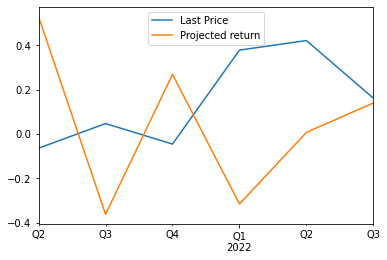

In [14]:
output = pd.concat([df_test, forecast_arma['Projected return']], axis=1)
output.plot()
plt.show()

# <font color='blue'> Time to build an alternative model:

Here are the exogenous explanatory variables downloaded from bloomberg that will help explaining the quarterly CDS returns:
- Euribor 3 months Index
- CAC40 Index
- EURUSD Curncy
- ECB Main Refinancing Operations Rate
- BNP FP Equity

In [15]:
df_2 = pd.read_excel('Variables.xlsx', index_col=0).dropna()
df_2 = df_2.sort_values(by='Date', ascending=True)
df_2

BNP CDS  EUR003M Index  CAC Index  EURUSD Curncy   ECB  \
Date                                                                 
2010-01-04   59.543          0.700    4013.97         1.4413  0.00   
2010-01-05   57.312          0.699    4012.91         1.4365  0.00   
2010-01-06   56.081          0.694    4017.67         1.4408  0.00   
2010-01-07   52.640          0.692    4024.80         1.4308  0.00   
2010-01-08   52.432          0.691    4045.14         1.4409  0.00   
...             ...            ...        ...            ...   ...   
2022-09-26   84.830          1.168    5769.39         0.9609  1.25   
2022-09-27   84.193          1.228    5753.82         0.9594  1.25   
2022-09-28   85.158          1.193    5765.01         0.9735  1.25   
2022-09-29   89.461          1.160    5676.87         0.9815  1.25   
2022-09-30   87.349          1.173    5762.34         0.9802  1.25   

            BNP FP Equity  
Date                       
2010-01-04         57.240  
2010-01-05         57.130  
2010-01-06         57.220  
2010-01-07         58.220  
2010-01-08         59.600  
...                   ...  
2022-09-26         46.210  
2022-09-27         45.110  
2022-09-28         43.350  
2022-09-29         42.535  
2022-09-30         43.605  

[3267 rows x 6 columns]

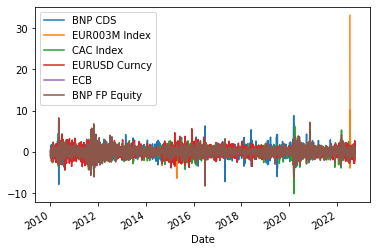

In [16]:
#===== Computing returns and standardizing them to get rid of scale effect ?? =================

df_returns = np.log(df_2).diff()
#standardized :
df_returns_std = (df_returns - np.mean(df_returns)) / np.std(df_returns)
df_returns_std.plot()
plt.show()

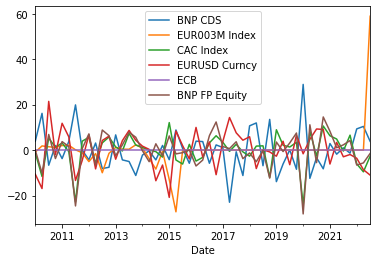

In [17]:
#========= Keeping only quartelry returns ===============

#compunting quarterly returns
df_returns_quarterly = df_returns_std.resample('Q').sum()
df_returns_quarterly.plot()
plt.show()

In [18]:
#split in train (from 01/01/2010 until 31/03/2022) and test (01/04/2022 until 30/09/2022):
df2_train = df_returns_quarterly.loc['2010-03-31' : '2021-03-31']
df2_test = df_returns_quarterly.loc['2021-06-30' : '2022-09-30']

## 1. The ARIMAX model:

In [19]:
#===== Checking for unit root in the series ===========

def adf_outputs(df):
    test = adfuller(df)
    df_adf = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=[df.name])
    df_adf[df.name]['Test Statistic Value'] = test[0]
    df_adf[df.name]['p-value'] = test[1]
    df_adf[df.name]['Lags Used'] = test[2]
    df_adf[df.name]['Number of Observations Used'] = test[3]
    df_adf[df.name]['Critical Value(1%)'] = test[4]['1%']
    df_adf[df.name]['Critical Value(5%)'] = test[4]['5%']
    df_adf[df.name]['Critical Value(10%)'] = test[4]['10%']
    
    return df_adf

list = [df2_train['CAC Index'],df2_train['EURUSD Curncy'], df2_train['ECB'], df2_train['BNP FP Equity']]
adf_summary = adf_outputs(df2_train['EUR003M Index'])
for i in range(len(list)):
    adf_summary = pd.merge(adf_summary, adf_outputs(list[i]), left_index=True, right_index=True)

adf_summary

EUR003M Index CAC Index EURUSD Curncy       ECB  \
Test Statistic Value             -4.51906 -8.137827     -7.060095       NaN   
p-value                          0.000182       0.0           0.0       NaN   
Lags Used                               0         0             0         0   
Number of Observations Used            44        44            44        44   
Critical Value(1%)              -3.588573 -3.588573     -3.588573 -3.588573   
Critical Value(5%)              -2.929886 -2.929886     -2.929886 -2.929886   
Critical Value(10%)             -2.603185 -2.603185     -2.603185 -2.603185   

                            BNP FP Equity  
Test Statistic Value            -8.115436  
p-value                               0.0  
Lags Used                               0  
Number of Observations Used            44  
Critical Value(1%)              -3.588573  
Critical Value(5%)              -2.929886  
Critical Value(10%)             -2.603185

In [20]:
'''print(adfuller(df2_train['EUR003M Index']))
print(adfuller(df2_train['CAC Index']))
print(adfuller(df2_train['EURUSD Curncy']))
print(adfuller(df2_train['ECB']))
print(adfuller(df2_train['BNP FP Equity']))'''
# ADF test v1 d'Ariane: c'est plus lisible en haut je trouve

"print(adfuller(df2_train['EUR003M Index']))\nprint(adfuller(df2_train['CAC Index']))\nprint(adfuller(df2_train['EURUSD Curncy']))\nprint(adfuller(df2_train['ECB']))\nprint(adfuller(df2_train['BNP FP Equity']))"

For all time series, we can reject the null of unit root processes. The processes are thus **stationary** and there is no need for differenciation nor de-trending.

In [21]:
#=== Creating the data frame with the exogenous variables =======
#df_diff=pd.DataFrame(index=df2_train.index)
#df_diff['E3M'] = df2_train['EUR003M Index'] #=== not differenciating for this time series which is stationnary
#df_diff['CAC40'] = df2_train['CAC Index'].diff()
#df_diff['EURUSD'] = df2_train['EURUSD Curncy'].diff()
#df_diff['ECB'] = df2_train['ECB'].diff()
#df_diff['BNP Equity'] = df2_train['BNP FP Equity'].diff()
#df_diff.head()

In [22]:
#=== Make sure the differenced time-series are stationary =======

#list = [df_diff['CAC40'].dropna(),df_diff['EURUSD'].dropna(), df_diff['ECB'].dropna(), df_diff['BNP Equity'].dropna()]
#adf_summary = adf_outputs(df_diff['E3M'].dropna())
#for i in range(len(list)):
 #   adf_summary = pd.merge(adf_summary, adf_outputs(list[i]), left_index=True, right_index=True)

#adf_summary

In [23]:
#========= fitting an ARIMAX model =================

arimax_model  = tsa.arima.model.ARIMA(endog=df2_train['BNP CDS'],
                                      exog=df2_train[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']],
                                            order=(4,0,1)).fit()
arimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                BNP CDS   No. Observations:                   45
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -136.779
Date:                Sat, 24 Dec 2022   AIC                            297.559
Time:                        13:46:09   BIC                            319.239
Sample:                    03-31-2010   HQIC                           305.641
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4827      0.573     -0.842      0.400      -1.606       0.640
EUR003M Index    -0.0272      0.150     -0.182      0.856      -0.321       0.266
CAC Index        -0.5164      0.451     -1.145      0.252      -1.400       0.368
EURUSD Curncy    -0.1557      0.145     -1.075      0.283      -0.440       0.128
ECB                    0   1.27e-06          0      1.000   -2.49e-06    2.49e-06
BNP FP Equity    -0.4143      0.357     -1.162      0.245      -1.113       0.285
ar.L1            -0.2831      0.625     -0.453      0.650      -1.507       0.941
ar.L2            -0.2014      0.219     -0.920      0.357      -0.630       0.228
ar.L3            -0.2599      0.264     -0.983      0.326      -0.778       0.258
ar.L4            -0.4235      0.254     -1.665      0.096      -0.922       0.075
ma.L1            -0.0039      0.738     -0.005      0.996      -1.450       1.442
sigma2           25.0384      5.567      4.497      0.000      14.127      35.950
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.80
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               1.36   Skew:                            -0.61
Prob(H) (two-sided):                  0.55   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.01e+19. Standard errors may be unstable.
"""

## Forecasts of the ARIMAX model:

In [24]:
forecast_arimax = arimax_model.forecast(6, exog=df2_test[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']])
forecast_arimax = pd.DataFrame({'Projected return' : forecast_arimax})
forecast_arimax

Projected return
2021-06-30         -5.336528
2021-09-30         -1.394989
2021-12-31         -9.419207
2022-03-31          3.724801
2022-06-30         10.338851
2022-09-30          2.778673

## Graph comparaison of forecasts versus real values:

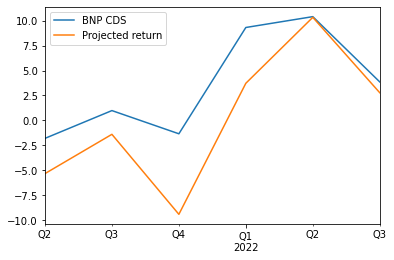

In [25]:
output2 = pd.concat([df2_test['BNP CDS'], forecast_arimax['Projected return']], axis=1)
output2.plot()
plt.show()

Ariane: arpès je crois y a des erreurs de forecasts à calculer maybe mais je sais pas exactement comment...

## 2. The ARDL model:

In [26]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

sel_res = ardl_select_order(endog = df2_train['BNP CDS'], maxlag = 5, exog = df2_train[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']], trend="c", maxorder = 5, ic="aic")
print(f"The optimal order is: {sel_res.model.ardl_order}")

The optimal order is: (5, 1, 5, 4)


In [27]:
res2 = sel_res.model.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                BNP CDS   No. Observations:                   45
Model:               ARDL(5, 1, 5, 4)   Log Likelihood                -108.760
Method:               Conditional MLE   S.D. of innovations              3.670
Date:                Sat, 24 Dec 2022   AIC                            257.520
Time:                        13:46:55   BIC                            291.298
Sample:                    06-30-2011   HQIC                           269.733
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.1892      1.104     -2.890      0.009      -5.484      -0.894
BNP CDS.L1          -0.3654      0.167     -2.182      0.041      -0.714      -0.017
BNP CDS.L2           0.0480      0.173      0.277      0.784      -0.311       0.407
BNP CDS.L3          -0.0566      0.166     -0.342      0.736      -0.401       0.288
BNP CDS.L4          -0.5548      0.157     -3.528      0.002      -0.882      -0.228
BNP CDS.L5          -0.1461      0.133     -1.100      0.284      -0.422       0.130
EUR003M Index.L0    -0.1746      0.237     -0.737      0.469      -0.667       0.318
EUR003M Index.L1    -0.5309      0.242     -2.198      0.039      -1.033      -0.029
EURUSD Curncy.L0    -0.2099      0.133     -1.580      0.129      -0.486       0.066
EURUSD Curncy.L1     0.0398      0.170      0.234      0.817      -0.313       0.393
EURUSD Curncy.L2     0.3110      0.173      1.802      0.086      -0.048       0.670
EURUSD Curncy.L3     0.3168      0.137      2.313      0.031       0.032       0.602
EURUSD Curncy.L4     0.0813      0.126      0.645      0.526      -0.181       0.343
EURUSD Curncy.L5    -0.3184      0.117     -2.722      0.013      -0.562      -0.075
BNP FP Equity.L0    -0.7429      0.117     -6.350      0.000      -0.986      -0.500
BNP FP Equity.L1    -0.1715      0.169     -1.013      0.323      -0.524       0.181
BNP FP Equity.L2    -0.0901      0.179     -0.503      0.620      -0.463       0.283
BNP FP Equity.L3    -0.2949      0.178     -1.658      0.112      -0.665       0.075
BNP FP Equity.L4    -0.7954      0.184     -4.329      0.000      -1.177      -0.413
====================================================================================
"""

## Forecasts of the ARDL model:

In [28]:
forecast_ardl = res2.forecast(6, exog=df2_test[['EUR003M Index','CAC Index','EURUSD Curncy','ECB','BNP FP Equity']])
forecast_ardl = pd.DataFrame({'Projected return' : forecast_ardl})
forecast_ardl

Projected return
2021-06-30         -6.791434
2021-09-30          1.996478
2021-12-31        -19.823224
2022-03-31         -1.337203
2022-06-30          5.366130
2022-09-30        -15.986499

## Graph comparaison of forecasts versus real values:

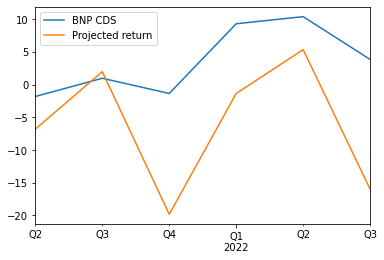

In [29]:
output2 = pd.concat([df2_test['BNP CDS'], forecast_ardl['Projected return']], axis=1)
output2.plot()
plt.show()

Ariane: Bon... ARIMAX rendait mieux, mnt faut qu'on arrive à comparer les erreurs des deux forecasts et conclure pour choisir le meilleur fit ;)